# Animal Center Outcome Correlations

### Research Question
- Does animal type, animal age, or animal sex upon outcome affect the animal’s outcome leaving an animal shelter?

Import needed librairies

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway

### Load in data and explore

In [2]:
df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [3]:
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,5/8/2019 18:20,May-19,5/2/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,7/18/2018 16:02,Jul-18,7/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,8/16/2020 11:38,Aug-20,8/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2/13/2016 17:59,Feb-16,10/8/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,3/18/2014 11:47,Mar-14,3/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


Multiple columns including "Outcome Type", "Animal Type", "Sex upon Outcome", and "Age upon Outcome"

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163638 entries, 0 to 163637
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         163638 non-null  object
 1   Name              116627 non-null  object
 2   DateTime          163638 non-null  object
 3   MonthYear         163638 non-null  object
 4   Date of Birth     163638 non-null  object
 5   Outcome Type      163599 non-null  object
 6   Outcome Subtype   75187 non-null   object
 7   Animal Type       163638 non-null  object
 8   Sex upon Outcome  163636 non-null  object
 9   Age upon Outcome  163622 non-null  object
 10  Breed             163638 non-null  object
 11  Color             163638 non-null  object
dtypes: object(12)
memory usage: 15.0+ MB


163,638 individual entries with name and outcome subtype having a lot of null values.

In [5]:
df['Animal Type'].value_counts()

Animal Type
Dog          90098
Cat          64169
Other         8523
Bird           820
Livestock       28
Name: count, dtype: int64

Main bulk of data is Dogs and Cats

In [6]:
df['Outcome Type'].value_counts()

Outcome Type
Adoption           78108
Transfer           46623
Return to Owner    24952
Euthanasia         10299
Died                1546
Rto-Adopt           1154
Disposal             797
Missing               86
Relocate              27
Stolen                 5
Lost                   2
Name: count, dtype: int64

Main bulk of data is Adoption, Transfer, Return to Owner, and Euthanasia

### Copy df and filter to data needed

- Copy dataframe
- Drop n/a values in "Outcome Type", "Age upon Outcome", "Sex upon Outcome"
- Remove all animals types other than Dog and Cat
- Remove all ages that contain day(s), week(s), and month(s) and any age of 0
- Remove word year(s) from "Age upon Outcome"
- Filter to ages between 1 and 18 and change data type to int
- Filter "Outcome Type" to Adoption, Transfer, Euthanasia, and Return to Owner
- Have "Outcome Type" and "Sex upon Outcome" as strings
- Remove further unknown and nan values

In [7]:
df1 = df.copy()

In [8]:
# Drop n/a values in needed columns (Outcome Type, Age upon Outcome, Sex upon Outcome)
df1 = df1.dropna(subset=['Outcome Type'])
df1 = df1.dropna(subset=['Age upon Outcome'])
df1 = df1.dropna(subset=['Sex upon Outcome'])

In [9]:
# Drop Other, Bird, and Livestock from Animal Type
df1 = df1[~df1['Animal Type'].isin(['Other', 'Bird', 'Livestock'])]

In [10]:
# Remove day(s), week(s), month(s)
df1 = df1[~df1['Age upon Outcome'].str.contains('day|days|week|weeks|month|months')]
df1 = df1[df1['Age upon Outcome'] != 0]

In [11]:
df1['Age upon Outcome'] = df1['Age upon Outcome'].str.replace(' years', '', regex=False)
df1['Age upon Outcome'] = df1['Age upon Outcome'].str.replace(' year', '', regex=False)

In [12]:
# Filter to Ages > 1 year and <= 18
df1['Age upon Outcome'] = df1['Age upon Outcome'].astype(int)
df1 = df1[(df1['Age upon Outcome'] > 0) & (df1['Age upon Outcome'] <= 18)]

In [13]:
# Remove Outcome Types Died|Disposal|Lost|Missing|Relocate|Rto-Adopt|Stolen|Unknown
df1['Outcome Type'] = df1['Outcome Type'].astype(str)
df1 = df1[~df1['Outcome Type'].str.contains('Died|Disposal|Lost|Missing|Relocate|Rto-Adopt|Stolen|Unknown')]
df1 = df1[~df1['Outcome Type'].isin(['nan'])]
outcome_counts = df1['Outcome Type'].value_counts()

In [14]:
# Change Outcome Type and Sex upon Outcome to string
df1['Outcome Type'] = df1['Outcome Type'].astype(str)
df1['Sex upon Outcome'] = df1['Sex upon Outcome'].astype(str)

In [15]:
# Remove unknown values from Sex upon Outcome
df1 = df1[~df1['Sex upon Outcome'].isin(['Unknown'])]

In [16]:
# remove nan from Outcome Type and Sex upon Outcome
df1 = df1[~df1['Sex upon Outcome'].isin(['nan'])]
df1 = df1[~df1['Outcome Type'].isin(['nan'])]

## Verify Changes

In [17]:
df1.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
1,A776359,Gizmo,7/18/2018 16:02,Jul-18,7/12/2017,Adoption,NaN,Dog,Neutered Male,1,Chihuahua Shorthair Mix,White/Brown
5,A659412,Princess,10/5/2020 14:37,Oct-20,3/24/2013,Adoption,NaN,Dog,Spayed Female,7,Chihuahua Shorthair Mix,Brown
6,A814515,Quentin,5/6/2020 7:59,May-20,3/1/2018,Adoption,Foster,Dog,Neutered Male,2,American Foxhound/Labrador Retriever,White/Brown
10,A840370,Tulip,8/19/2021 19:36,Aug-21,8/6/2019,Adoption,NaN,Dog,Spayed Female,2,Border Collie/Cardigan Welsh Corgi,Black/White
11,A684617,NaN,7/27/2014 9:00,Jul-14,7/26/2012,Transfer,SCRP,Cat,Intact Female,2,Domestic Shorthair Mix,Black


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80277 entries, 1 to 163634
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Animal ID         80277 non-null  object
 1   Name              69427 non-null  object
 2   DateTime          80277 non-null  object
 3   MonthYear         80277 non-null  object
 4   Date of Birth     80277 non-null  object
 5   Outcome Type      80277 non-null  object
 6   Outcome Subtype   28870 non-null  object
 7   Animal Type       80277 non-null  object
 8   Sex upon Outcome  80277 non-null  object
 9   Age upon Outcome  80277 non-null  int32 
 10  Breed             80277 non-null  object
 11  Color             80277 non-null  object
dtypes: int32(1), object(11)
memory usage: 7.7+ MB


In [19]:
# Verify and get value counts & percentages of only Cats and Dogs
animal_counts = df1['Animal Type'].value_counts()
print(animal_counts)
percentages_cat_dog = animal_counts / animal_counts.sum() * 100
print(percentages_cat_dog)

Animal Type
Dog    60068
Cat    20209
Name: count, dtype: int64
Animal Type
Dog    74.825915
Cat    25.174085
Name: count, dtype: float64


In [20]:
# Counts of ages between 1 and 18
age_counts = df1['Age upon Outcome'].value_counts()
age_counts

Age upon Outcome
1     22576
2     22491
3      8742
4      5266
5      4830
6      3182
7      2798
8      2762
10     2190
9      1526
12     1087
11      866
13      691
14      492
15      429
16      185
17      105
18       59
Name: count, dtype: int64

In [21]:
# Value counts of Sex upon Outcome
sex_counts = df1['Sex upon Outcome'].value_counts()
sex_counts

Sex upon Outcome
Neutered Male    34107
Spayed Female    28997
Intact Male       8686
Intact Female     8487
Name: count, dtype: int64

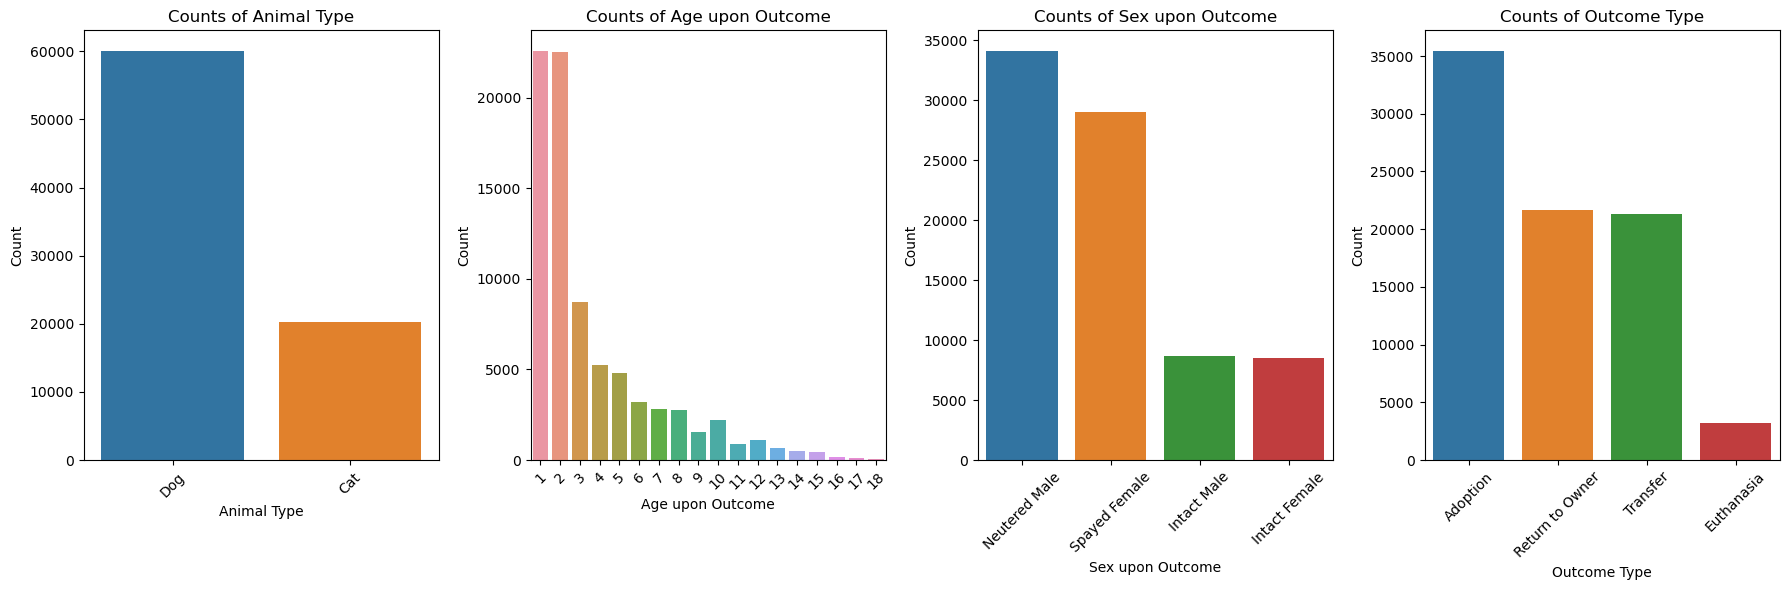

In [22]:
# Plotting the counts
plt.figure(figsize=(18,6))

# Plot for Animal Type counts
plt.subplot(1, 4, 1)
sns.barplot(x=animal_counts.index, y=animal_counts.values)
plt.title('Counts of Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot for Age upon Outcome Types
plt.subplot(1, 4, 2)
sns.barplot(x=age_counts.index, y=age_counts.values)
plt.title('Counts of Age upon Outcome')
plt.xlabel('Age upon Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot for Sex upon Outcome counts
plt.subplot(1, 4, 3)
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title('Counts of Sex upon Outcome')
plt.xlabel('Sex upon Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot for Outcome Type counts
plt.subplot(1, 4, 4)
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Counts of Outcome Type')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Outcome type based on Animal Type

- Create contingency table for animal type
- Calculate chi2 and p-value
- Plot contingency table
- Create separate Cat and Dog count percentages and plot
- 

In [23]:
contingency_table_type = pd.crosstab(df1['Animal Type'], df1['Outcome Type'])
print(contingency_table_type)

Outcome Type  Adoption  Euthanasia  Return to Owner  Transfer
Animal Type                                                  
Cat               8581        1226             2224      8178
Dog              26868        1762            19326     12112


In [24]:
chi2_type, p_type, dof, expected= chi2_contingency(contingency_table_type)

print("Chi-squared:", chi2_type)
print("P-value:", p_type)

Chi-squared: 5406.9124320324445
P-value: 0.0


Chi-Square of 5406.912 shows a large discrepancy between observed and expected frequencies in the data.
p-value of 0.0 shows the Chi-square would not be high without association.

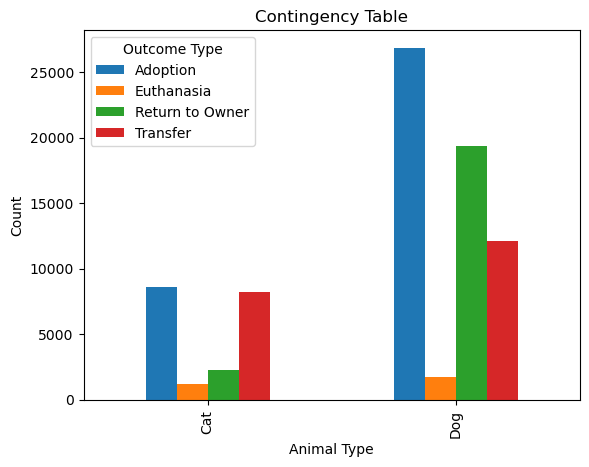

In [25]:
contingency_table_type.plot(kind='bar')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Contingency Table')
plt.legend(title='Outcome Type')
plt.show()

In [26]:
cat_df = df1[df1['Animal Type'] == 'Cat']
catgrouped = cat_df.groupby(['Animal Type', 'Outcome Type']).size().reset_index(name='Count')
total_count_cat = catgrouped.groupby('Animal Type')['Count'].transform('sum')
catgrouped['Percentage'] = (catgrouped['Count'] / total_count_cat) * 100
print(catgrouped)

  Animal Type     Outcome Type  Count  Percentage
0         Cat         Adoption   8581   42.461280
1         Cat       Euthanasia   1226    6.066604
2         Cat  Return to Owner   2224   11.004998
3         Cat         Transfer   8178   40.467119


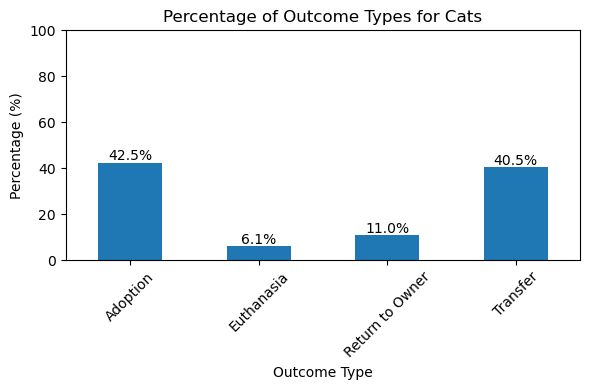

In [27]:
ax = catgrouped.plot(x='Outcome Type', y='Percentage', kind='bar', 
                     figsize=(6, 4), legend=False)
for index, row in catgrouped.iterrows():
    ax.text(index, row['Percentage']+1, f'{row["Percentage"]:.1f}%', 
            color='black', ha='center')
plt.xlabel('Outcome Type')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Outcome Types for Cats')
plt.xticks(rotation=45)
plt.ylim(0, 100) 
plt.tight_layout()
plt.show()

Majority of cats are Adopted or Transfer

In [28]:
dog_df = df1[df1['Animal Type'] == 'Dog']
doggrouped = dog_df.groupby(['Animal Type', 'Outcome Type']).size().reset_index(name='Count')
total_count_dog = doggrouped.groupby('Animal Type')['Count'].transform('sum')
doggrouped['Percentage'] = (doggrouped['Count'] / total_count_dog) * 100
print(doggrouped)

  Animal Type     Outcome Type  Count  Percentage
0         Dog         Adoption  26868   44.729307
1         Dog       Euthanasia   1762    2.933342
2         Dog  Return to Owner  19326   32.173537
3         Dog         Transfer  12112   20.163814


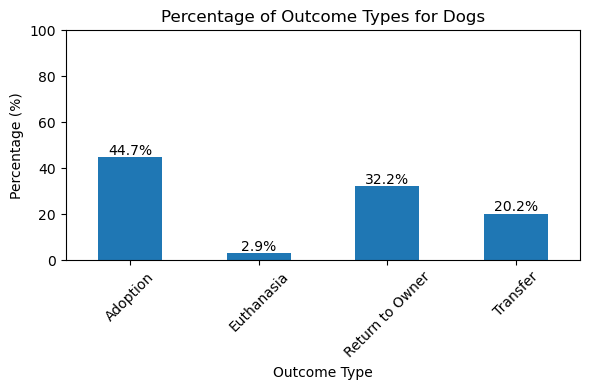

In [29]:
ax = doggrouped.plot(x='Outcome Type', y='Percentage', kind='bar', 
                     figsize=(6, 4), legend=False)
for index, row in doggrouped.iterrows():
    ax.text(index, row['Percentage']+1, f'{row["Percentage"]:.1f}%', 
            color='black', ha='center')
plt.xlabel('Outcome Type')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Outcome Types for Dogs')
plt.xticks(rotation=45)
plt.ylim(0, 100) 
plt.tight_layout()
plt.show()

Majority of Dogs are Adopted or Returned to Owner

## Outcome type based on Age upon Outcome

- Create contingency table for outcome type and remove total column
- Calculate chi2 and p-value
- Create percentage table
- Plot contingency table and percentage table

In [30]:
contingency_table_age = pd.crosstab(df1['Age upon Outcome'], df1['Outcome Type'], margins=True, margins_name='Total')
contingency_table_age2 = contingency_table_age.iloc[:-1, :-1]
print(contingency_table_age)
print(contingency_table_age2)

Outcome Type      Adoption  Euthanasia  Return to Owner  Transfer  Total
Age upon Outcome                                                        
1                    11682         457             4067      6370  22576
2                    10430         747             5220      6094  22491
3                     3711         303             2660      2068   8742
4                     2125         205             1793      1143   5266
5                     1884         216             1606      1124   4830
6                     1187         118             1153       724   3182
7                     1033         107             1051       607   2798
8                     1072         159              947       584   2762
9                      608          82              592       244   1526
10                     693         170              766       561   2190
11                     283          44              389       150    866
12                     291         142             

In [31]:
chi2_age, p_age, dof, expected = chi2_contingency(contingency_table_age2)
print("Chi-squared:", chi2_age)
print("P-value:", p_age)

Chi-squared: 3985.423074123817
P-value: 0.0


Chi-Square of 3985.423 shows a large discrepancy between observed and expected frequencies in the data. P-value of 0.0 shows the Chi-square would not be high without association.

In [32]:
percentage_table1 = contingency_table_age.div(contingency_table_age['Total'], axis=0) * 100
percentage_table1 = percentage_table1.drop(columns='Total')  # Drop the 'Total' column from percentages
percentage_table1 = percentage_table1.iloc[ :-1]

print("Percentage of Outcome Types by Age upon Outcome:")
print(percentage_table1)

Percentage of Outcome Types by Age upon Outcome:
Outcome Type       Adoption  Euthanasia  Return to Owner   Transfer
Age upon Outcome                                                   
1                 51.745216    2.024274        18.014706  28.215804
2                 46.374105    3.321329        23.209284  27.095283
3                 42.450240    3.466026        30.427820  23.655914
4                 40.353209    3.892898        34.048614  21.705279
5                 39.006211    4.472050        33.250518  23.271222
6                 37.303583    3.708360        36.235072  22.752986
7                 36.919228    3.824160        37.562545  21.694067
8                 38.812455    5.756698        34.286749  21.144098
9                 39.842726    5.373526        38.794233  15.989515
10                31.643836    7.762557        34.977169  25.616438
11                32.678984    5.080831        44.919169  17.321016
12                26.770929   13.063477        35.786569  24.379025

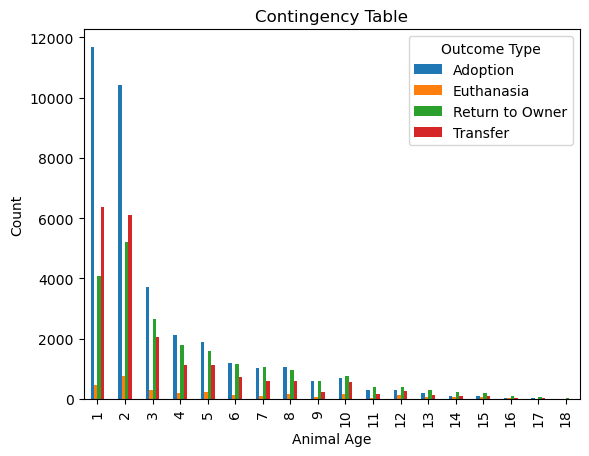

In [33]:
contingency_table_age = contingency_table_age.iloc[:-1, :-1]

contingency_table_age.plot(kind='bar')
plt.xlabel('Animal Age')
plt.ylabel('Count')
plt.title('Contingency Table')
plt.legend(title='Outcome Type')
plt.show()

Can see elevated number of younger animals but cannot see the outcome types clearly, move to percentage plot to see better visual

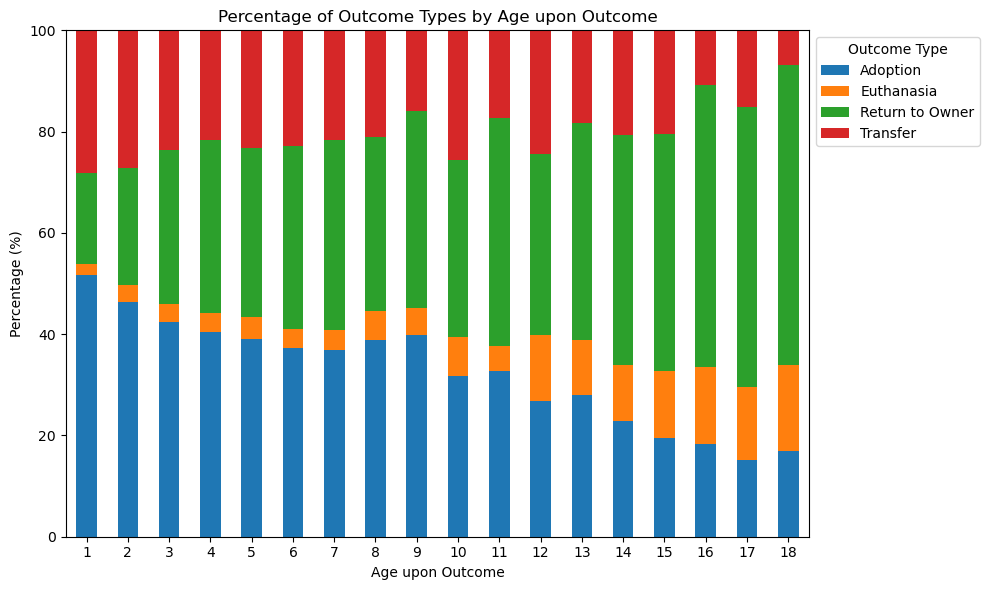

In [34]:
percentage_table1.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Age upon Outcome')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Outcome Types by Age upon Outcome')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Outcome Type', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.ylim(0, 100)  # Ensure y-axis starts from 0 and ends at 100

plt.tight_layout()
plt.show()

- As age increases, Adoption and Transfer decreases
- As age increases, Return to Owner and Euthanasia increases


### Sex upon Outcome vs Outcome Type

- Create a contingency table for Sex upon Outcome
- Find chi2 and p-value
- Create percentage table
- Plot contingency and percentage table

In [35]:
contingency_table_sex = pd.crosstab(df1['Sex upon Outcome'], df1['Outcome Type'], margins=True, margins_name='Total')
contingency_table_sex2 = contingency_table_sex.iloc[:-1, :-1]
print(contingency_table_sex)
print(contingency_table_sex2)

Outcome Type      Adoption  Euthanasia  Return to Owner  Transfer  Total
Sex upon Outcome                                                        
Intact Female          370         693             2408      5016   8487
Intact Male            343         862             3776      3705   8686
Neutered Male        17963         884             8862      6398  34107
Spayed Female        16773         549             6504      5171  28997
Total                35449        2988            21550     20290  80277
Outcome Type      Adoption  Euthanasia  Return to Owner  Transfer
Sex upon Outcome                                                 
Intact Female          370         693             2408      5016
Intact Male            343         862             3776      3705
Neutered Male        17963         884             8862      6398
Spayed Female        16773         549             6504      5171


In [36]:
chi2_sex, p_sex, dof, expected = chi2_contingency(contingency_table_sex2)
print("Chi-squared:", chi2_sex)
print("P-value:", p_sex)

Chi-squared: 16949.66193180815
P-value: 0.0


Chi-Square of 16949.662 shows a large discrepancy between observed and expected frequencies in the data. P-value of 0.0 shows the Chi-square would not be high without association.0

In [37]:
percentage_table3 = contingency_table_sex.div(contingency_table_sex['Total'], axis=0) * 100
percentage_table3 = percentage_table3.drop(columns='Total')  # Drop the 'Total' column from percentages
percentage_table3 = percentage_table3.iloc[ :-1]

print("Percentage of Outcome Types by Age upon Outcome:")
print(percentage_table3)

Percentage of Outcome Types by Age upon Outcome:
Outcome Type       Adoption  Euthanasia  Return to Owner   Transfer
Sex upon Outcome                                                   
Intact Female      4.359609    8.165429        28.372805  59.102156
Intact Male        3.948883    9.924016        43.472254  42.654847
Neutered Male     52.666608    2.591843        25.982936  18.758613
Spayed Female     57.843915    1.893299        22.429907  17.832879


In [38]:
contingency_table_sex = contingency_table_sex.iloc[:-1, :-1]

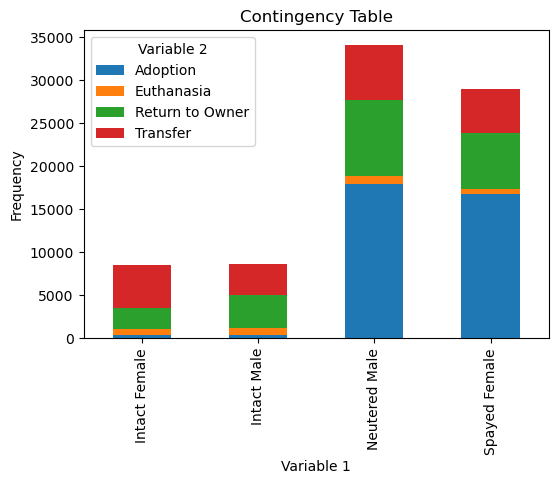

In [39]:
contingency_table_sex.plot(kind='bar', stacked=True, figsize=(6,4))
plt.xlabel('Variable 1')
plt.ylabel('Frequency')
plt.title('Contingency Table')
plt.legend(title='Variable 2')
plt.show()

- High counts of Neutered Males and Spayed Females with majority of Adopted
- Low counts of adoption with Intact Males and Females
- Check percentage table for easier to look at visual

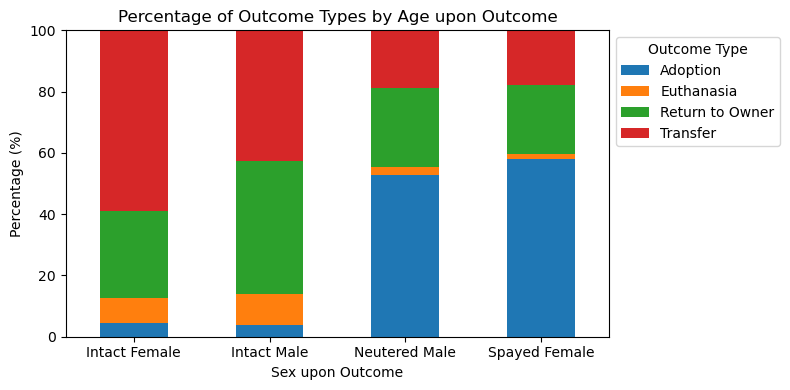

In [40]:
percentage_table3.plot(kind='bar', stacked=True, figsize=(8, 4))

# Adding labels and title
plt.xlabel('Sex upon Outcome')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Outcome Types by Age upon Outcome')
plt.xticks(rotation=0)  
plt.legend(title='Outcome Type', bbox_to_anchor=(1, 1))
plt.ylim(0, 100)  # Ensure y-axis starts from 0 and ends at 100

plt.tight_layout()
plt.show()

- High percentage of Neutered Males and Spayed Females are adopted
- Intact Females mainly Transferred
- Intact Males transferred and returned to owners and have higher rates of euthanasia compared to neutered males and spayed females

In [41]:
df1.to_csv('Animal_Shelter_Outcome_Clean.csv', index=False)

## Overall Conclusions

- Null Hypothesis 1: There is no significant correlation between animal types and positive adoption outcomes
> Reject due to chi-square and p-value of 5406.912 and 0.0
- Null Hypothesis 2: There is no significant correlation between the age of the animals and positive adoption outcomes
> Reject due to chi-square and p-value of 3985.423 and 0.0
- Null Hypothesis 3: There is no significant correlation between sex upon outcome and positive adoption outcomes
> Reject due to chi-square and p-value of 16949.662 and 0.0